# Quantative Precipitation Forecast Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [14]:
from datetime import datetime
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import scipy.ndimage as ndimage
from dk_met_io.retrieve_micaps_server import get_model_grid
from dk_met_graphics.plot.china_map import add_china_map_2cartopy
from dk_met_graphics.plot.util import add_logo, add_model_title

# 模式降水预报

In [3]:
initial_time = '18042008'
fhour = 36
model = 'ECMWF'

# micaps data directory
data_dirs = {'ECMWF': ['ECMWF_HR/RAIN24']}
try:
    data_dir = data_dirs[model.strip().upper()]
except KeyError:
    raise ValueError('Unknown model, choose ECMWF, GRAPES or NCEP.')

# get filename
if isinstance(initial_time, datetime):
    filename = initial_time.strftime('%y%m%d%H') + ".{:03d}".format(fhour)
else:
    filename = initial_time.strip() + ".{:03d}".format(fhour)

# retrieve data from micaps server
rain24 = get_model_grid(data_dir[0], filename=filename)
init_time = rain24.coords['init_time'].values[0]

# prepare data
rain24 = {'lon': rain24.coords['lon'].values,
          'lat': rain24.coords['lat'].values,
          'data': np.squeeze(rain24.values)}

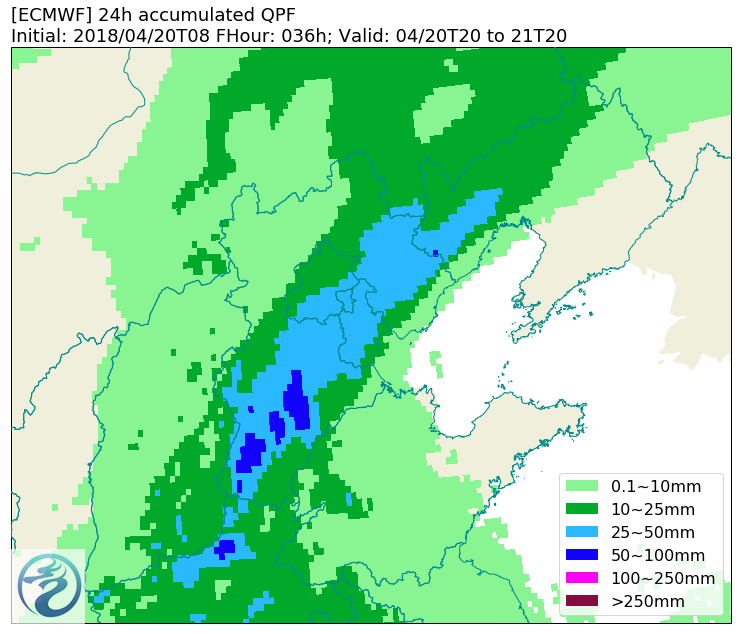

In [17]:
# draw figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0, 0, 1, 1], projection=plotcrs)
plotcrs = ccrs.AlbersEqualArea(
    central_latitude=35., central_longitude=110.,
    standard_parallels=[30., 60.])

# draw main figure
add_model_title(
    '24h accumulated QPF', init_time,
    model=model, fhour=fhour, fontsize=18,
    multilines=True, atime=24)

# set level and colors
datacrs = ccrs.PlateCarree()
plots = {}
ax.set_extent((110, 124, 34, 44), crs=datacrs)
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
ax.add_feature(land_50m)
add_china_map_2cartopy(ax, name='province', edgecolor='darkcyan', lw=1, zorder=100)
clevs = [0.1, 10, 25, 50, 100, 250]
colors = ["#88F492", "#00A929", "#2AB8FF", "#1202FC", "#FF04F4", "#850C3E"]
cmap, norm = mpl.colors.from_levels_and_colors(clevs, colors, extend='max')
plots['rain24'] = ax.pcolormesh(rain24['lon'], rain24['lat'], rain24['data'], norm=norm,
                                cmap=cmap, transform=datacrs, zorder=2)

# add custom legend
legend_elements = [
    Patch(facecolor=colors[0], label='0.1~10mm'),
    Patch(facecolor=colors[1], label='10~25mm'),
    Patch(facecolor=colors[2], label='25~50mm'),
    Patch(facecolor=colors[3], label='50~100mm'),
    Patch(facecolor=colors[4], label='100~250mm'),
    Patch(facecolor=colors[5], label='>250mm')]
ax.legend(handles=legend_elements, loc='lower right', fontsize=16)

# add logo
add_logo(fig, alpha=0.7)

# show figure
ax.set_adjustable('datalim')
plt.show()